In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylidc as pl
from project_config import env_config

nodule_df_path = env_config.nodule_df_file
nodule_processed_df_path = env_config.processed_nodule_df_file
hold_out_nodule_df_path = env_config.hold_out_nodule_df_file

plots_path = "report/plots"

## Distribution of annotations malignancy

6859

37.99387665840502

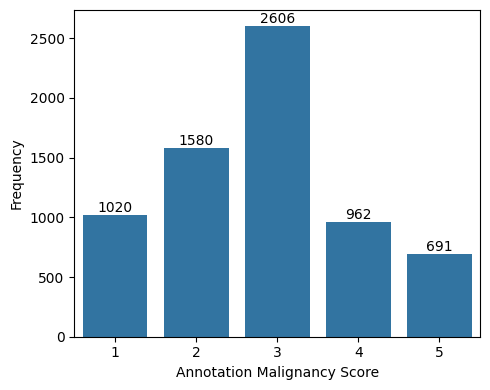

In [75]:
annotation_malignancy_counts = [
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 1).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 2).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 3).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 4).count(),
    pl.query(pl.Annotation).filter(pl.Annotation.malignancy == 5).count(),
]

total = (sum(annotation_malignancy_counts))
display(total)

# calculate percentage == 3
percentage = annotation_malignancy_counts[2] / total * 100
display(percentage)

plt.figure(figsize=(5, 4))
sns.barplot(x=[1, 2, 3, 4, 5], y=annotation_malignancy_counts)
for i, count in enumerate(annotation_malignancy_counts):
    plt.text(i, count, count, ha='center', va='bottom')
plt.xlabel('Annotation Malignancy Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(f'{plots_path}/malignancy_score_distribution.png')

## Distribution of ALL nodules consensus malignancy

In [9]:
nodule_df = pd.read_csv(nodule_df_path)
nodule_processed_df = pd.read_csv(nodule_processed_df_path)
hold_out_nodule_df = pd.read_csv(hold_out_nodule_df_path)

In [16]:
display(hold_out_nodule_df.head())
display(nodule_processed_df.head())

,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,consensus_centroid,...,bbox_10_standardised,bbox_20_standardised,bbox_30_standardised,bbox_40_standardised,bbox_50_standardised,bbox_60_standardised,bbox_70_standardised,bbox_80_standardised,bbox_90_standardised,bbox_100_standardised
0,0_LIDC-IDRI-0007,LIDC-IDRI-0007,0,34.442066,8296.775818,"(124, 126, 127, 128)",4,"(5, 5, 5, 4)","(5, 5, 5, 5)","(289, 194, 107)",...,True,True,True,True,True,True,True,False,False,False
1,0_LIDC-IDRI-0037,LIDC-IDRI-0037,0,18.539941,1601.196289,"(348, 351, 352, 353)",4,"(4, 5, 3, 4)","(5, 5, 5, 5)","(288, 407, 82)",...,True,True,True,True,True,True,True,True,True,True
2,0_LIDC-IDRI-0064,LIDC-IDRI-0064,0,29.790760,10658.264160,"(661, 664, 666, 667)",4,"(3, 4, 3, 2)","(5, 5, 5, 3)","(252, 397, 77)",...,True,True,True,True,True,True,True,True,True,True
3,0_LIDC-IDRI-0068,LIDC-IDRI-0068,0,6.046273,84.625246,"(700, 706, 710, 713)",4,"(2, 3, 3, 3)","(3, 4, 4, 3)","(341, 324, 118)",...,True,True,True,True,True,True,True,True,True,True
4,1_LIDC-IDRI-0068,LIDC-IDRI-0068,1,7.677837,148.441006,"(699, 705, 711, 714)",4,"(2, 3, 3, 4)","(3, 4, 4, 3)","(216, 411, 149)",...,True,True,True,True,True,True,True,True,True,True


,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,consensus_centroid,...,bbox_10_standardised,bbox_20_standardised,bbox_30_standardised,bbox_40_standardised,bbox_50_standardised,bbox_60_standardised,bbox_70_standardised,bbox_80_standardised,bbox_90_standardised,bbox_100_standardised
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)","(5, 5, 5, 5)","(366, 315, 89)",...,True,True,True,True,True,True,True,True,False,False
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,30.781671,7244.667508,"(88, 89)",2,"(5, 4)","(2, 1)","(361, 345, 185)",...,True,True,True,True,True,True,True,True,True,True
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(346, 368, 66)",...,True,True,True,True,True,True,True,True,True,True
3,1_LIDC-IDRI-0003,LIDC-IDRI-0003,1,31.001964,6519.463698,"(90, 93, 98, 99)",4,"(5, 5, 3, 4)","(5, 5, 5, 5)","(350, 366, 75)",...,True,True,True,True,True,True,True,True,True,True
4,2_LIDC-IDRI-0003,LIDC-IDRI-0003,2,13.309155,472.089669,"(91, 95, 97, 100)",4,"(4, 4, 3, 2)","(4, 4, 3, 3)","(197, 307, 82)",...,True,True,True,True,True,True,True,True,True,True


In [24]:
nodule_df.shape

(2625, 33)

In [ ]:
# total should be 2141
full_df = pd.concat([nodule_df, hold_out_nodule_df])
display(full_df.shape)

# full_df["pid"]

(2879, 33)